# Using CellTypist model of fetal cells for automatic cell annotation

In this tutorial we demonstrate how to use a [CellTypist](https://www.celltypist.org) model trained on the fetal immune atlas for automatic cell type annotation of new scRNA-seq datsets. A detailed description of the model can be found in [Conde, Xu et al. (2021)](https://www.biorxiv.org/content/10.1101/2021.04.28.441762v2).

This is a simplified version of the [CellTypist general tutorial](https://colab.research.google.com/github/Teichlab/celltypist/blob/main/docs/notebook/celltypist_tutorial.ipynb). Please refer to that tutorial for more functionalities, such as exploration of cell type driving genes.

## Getting started 

Install the celltypist python package

In [4]:
!pip install celltypist

In [103]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import celltypist

## Load model

In [2]:
!wget https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/celltypist_model.Pan_Fetal_Human.pkl

--2022-01-13 10:10:13--  https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/celltypist_model.Pan_Fetal_Human.pkl
Resolving cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)... 172.27.51.130, 172.27.51.129, 172.27.51.3, ...
Connecting to cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)|172.27.51.130|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4078788 (3.9M) [application/octet-stream]
Saving to: ‘celltypist_model.Pan_Fetal_Human.pkl’

celltypist_model.Pa 100%[===================>]   3.89M  --.-KB/s    in 0.04s   

2022-01-13 10:10:13 (102 MB/s) - ‘celltypist_model.Pan_Fetal_Human.pkl’ saved [4078788/4078788]



In [44]:
model = celltypist.models.Model.load(model = 'celltypist_model.Pan_Fetal_Human.pkl')

In [45]:
model.description

{'date': '2021-12-08 19:51:25.771934',
 'details': 'stromal and immune populations from the human fetus',
 'url': 'https://celltypist.cog.sanger.ac.uk/models/Pan_Fetal_Suo/Pan_Fetal_Human.pkl',
 'number_celltypes': 138}

We can have a look at the cell types included in this model

In [46]:
model.cell_types

array(['ABT(ENTRY)', 'AS_DC', 'B1', 'CD4+T', 'CD8+T', 'CD8AA',
       'CHONDROCYTE', 'CMP', 'CYCLING_B', 'CYCLING_DC',
       'CYCLING_EPITHELIUM', 'CYCLING_FIBROBLAST_I',
       'CYCLING_FIBROBLAST_II', 'CYCLING_ILC', 'CYCLING_MEMP',
       'CYCLING_MPP', 'CYCLING_NK', 'CYCLING_PDC', 'CYCLING_T',
       'CYCLING_YS_ERY', 'DC1', 'DC2', 'DC_PROGENITOR',
       'DEVELOPING_NEPHRON_I', 'DEVELOPING_NEPHRON_II', 'DN(P)_T',
       'DN(Q)_T', 'DN(early)_T', 'DOUBLET', 'DOUBLETS_FIBRO_ERY',
       'DOUBLET_ENDOTHELIUM_ERYTHROCYTE', 'DOUBLET_ERY_B',
       'DOUBLET_IMMUNE_FIBROBLAST', 'DOUBLET_LYMPHOID_MACROPHAGE',
       'DOUBLET_VSMC_ERYTHROCYTE', 'DP(P)_T', 'DP(Q)_T', 'EARLY_ERY',
       'EARLY_MK', 'ENDOTHELIUM_I', 'ENDOTHELIUM_II', 'ENDOTHELIUM_III',
       'ENDOTHELIUM_IV', 'ENDOTHELIUM_V', 'ENTEROENDOCRINE_I',
       'ENTEROENDOCRINE_II', 'EOSINOPHIL_BASOPHIL', 'EPITHELIUM_I',
       'EPITHELIUM_II', 'FIBROBLAST_I', 'FIBROBLAST_II', 'FIBROBLAST_III',
       'FIBROBLAST_IV', 'FIBROBLAST_I

## Load query dataset
In this tutorial we use predict cell identity in a scRNA-seq dataset generated from iPSC derived T cells (Artificial Thimic Organoids).

In [31]:
!wget https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/ATO_adata.h5ad

--2022-01-13 10:38:20--  https://cellgeni.cog.sanger.ac.uk/developmentcellatlas/fetal-immune/ATO_adata.h5ad
Resolving cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)... 172.27.51.3, 172.27.51.131, 172.27.51.1, ...
Connecting to cellgeni.cog.sanger.ac.uk (cellgeni.cog.sanger.ac.uk)|172.27.51.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211505998 (202M) [application/x-hdf]
Saving to: ‘ATO_adata.h5ad’

ATO_adata.h5ad      100%[===================>] 201.71M  33.8MB/s    in 8.8s    

2022-01-13 10:38:29 (22.8 MB/s) - ‘ATO_adata.h5ad’ saved [211505998/211505998]



In [32]:
query_adata = sc.read_h5ad('./ATO_adata.h5ad')

The expression matrix `query_adata.X` needs to be pre-processed as log1p normalised expression to 10,000 counts per cell.

In [34]:
sc.pp.normalize_per_cell(query_adata, counts_per_cell_after=1e4)
sc.pp.log1p(query_adata)

In [35]:
query_adata.X.expm1().sum(axis = 1)

matrix([[ 9999.999],
        [10000.   ],
        [10000.   ],
        ...,
        [10000.   ],
        [10000.   ],
        [10000.   ]], dtype=float32)

Some pre-existing cell annotation is present, which we will compare with the CellTypist prediction

In [37]:
query_adata.obs['annotation']

AAACCTGAGGCGACAT-1_6180STDY9448808      ERY
AAACCTGAGGTAGCTG-1_6180STDY9448808    DN/DP
AAACCTGCAATCCAAC-1_6180STDY9448808      ERY
AAACCTGCATCACGTA-1_6180STDY9448808      ERY
AAACCTGGTCAAGCGA-1_6180STDY9448808    DN/DP
                                      ...  
TTTGTCACAGGAATCG-1_6180STDY9448813     SP_T
TTTGTCACAGGGTACA-1_6180STDY9448813     SP_T
TTTGTCAGTAGCACGA-1_6180STDY9448813     SP_T
TTTGTCAGTAGTGAAT-1_6180STDY9448813    DN/DP
TTTGTCATCGGATGTT-1_6180STDY9448813    DN/DP
Name: annotation, Length: 10459, dtype: category
Categories (8, object): ['ABT(ENTRY)', 'DN/DP', 'ERY', 'HIGH_MITO', 'ILC3', 'MAST CELL', 'NK', 'SP_T']

This dataset was preprocessed with scVI

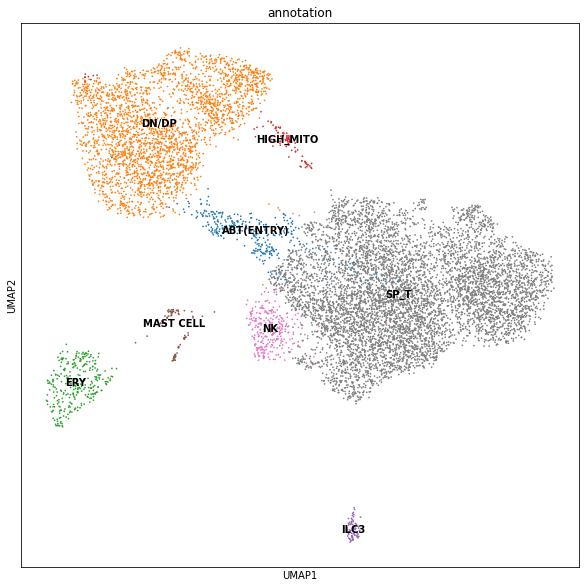

In [40]:
plt.rcParams['figure.figsize'] = [10,10]
sc.pl.umap(query_adata, color=['annotation'], legend_loc='on data')

## Predict cell identity
Let's make sure that the `query_adata.var_names` corresponds to the features used to train the model.

In [49]:
model.features

array(['TSPAN6', 'TNMD', 'DPM1', ..., 'AL513493.1', 'AC016831.7',
       'LINC00842'], dtype=object)

In [50]:
query_adata.var

,gene_ids,gene_names
ENSG00000000003,ENSG00000000003,TSPAN6
ENSG00000000005,ENSG00000000005,TNMD
ENSG00000000419,ENSG00000000419,DPM1
ENSG00000000457,ENSG00000000457,SCYL3
ENSG00000000460,ENSG00000000460,C1orf112
...,...,...
ENSG00000285492,ENSG00000285492,AL356417.3
ENSG00000285505,ENSG00000285505,AC010616.2
ENSG00000285508,ENSG00000285508,AL034430.1
ENSG00000285509,ENSG00000285509,AP000646.1


In [51]:
query_adata.var_names = query_adata.var.gene_names

We can use default settings to predict cell identity independently for each cell.

In [52]:
predictions = celltypist.annotate(query_adata, model = model)

🔬 Input data has 10459 cells and 33538 genes
🔗 Matching reference genes in the model
🧬 6971 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!


In [61]:
query_adata = predictions.to_adata()

In [62]:
n_cells = query_adata.obs['predicted_labels'].value_counts()
n_cells[0:30]

TYPE_1_INNATE_T                5478
DP(Q)_T                        1076
DP(P)_T                         781
DN(Q)_T                         540
CYCLING_NK                      488
CYCLING_T                       345
TYPE_3_INNATE_T                 327
YS_ERY                          248
HIGH_MITO                       197
CD8+T                           129
DN(P)_T                         118
TREG                            108
NK                               99
ILC3                             88
ABT(ENTRY)                       57
CD8AA                            48
MAST_CELL                        31
MACROPHAGE_ERY                   27
DN(early)_T                      26
CD4+T                            22
DOUBLET_LYMPHOID_MACROPHAGE      20
DOUBLET                          20
LOW_Q_INCONSISTENT               18
LATE_ERY                         16
PROMYELOCYTE                     14
DOUBLET_IMMUNE_FIBROBLAST         8
CYCLING_ILC                       8
MATURE_B                    

... storing 'predicted_labels' as categorical


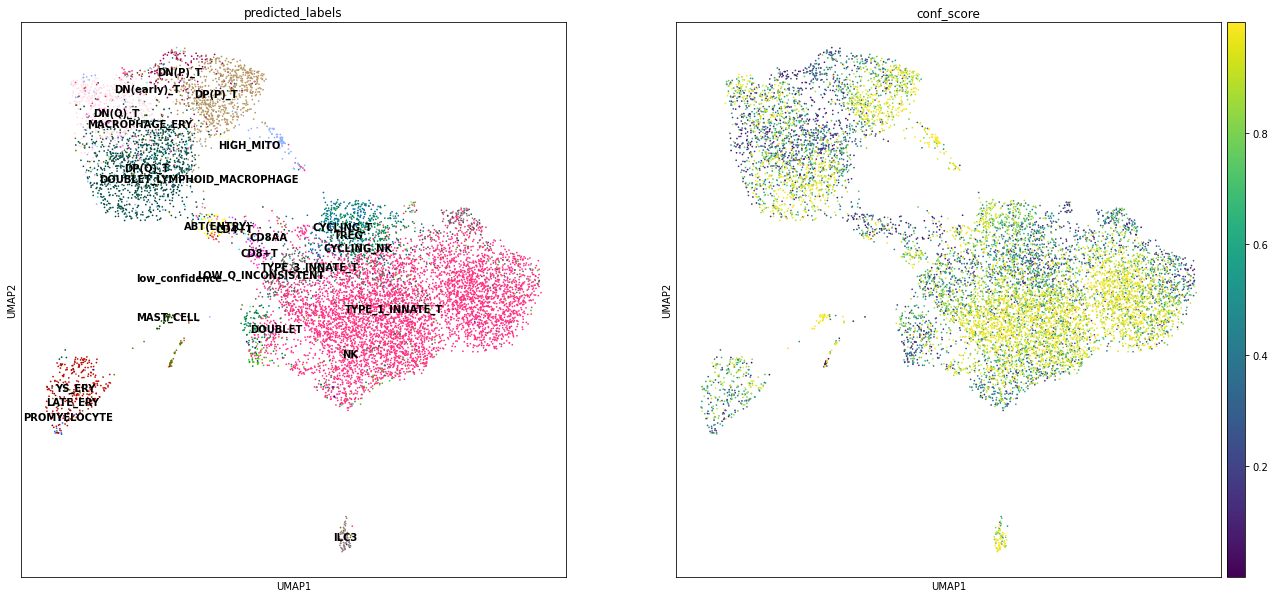

In [66]:
## Exclude low abundance predictions (if a label is given to less than 10 cells)
low_ab_predictions = n_cells.index[n_cells < 10]
query_adata.obs['predicted_labels'] = query_adata.obs['predicted_labels'].astype("str")
query_adata.obs.loc[query_adata.obs['predicted_labels'].isin(low_ab_predictions), 'predicted_labels'] = 'low_confidence'
sc.pl.umap(query_adata, color=['predicted_labels', 'conf_score'], legend_loc='on data')

The confidence score gives us a measure of uncertainty in the predicted annotation

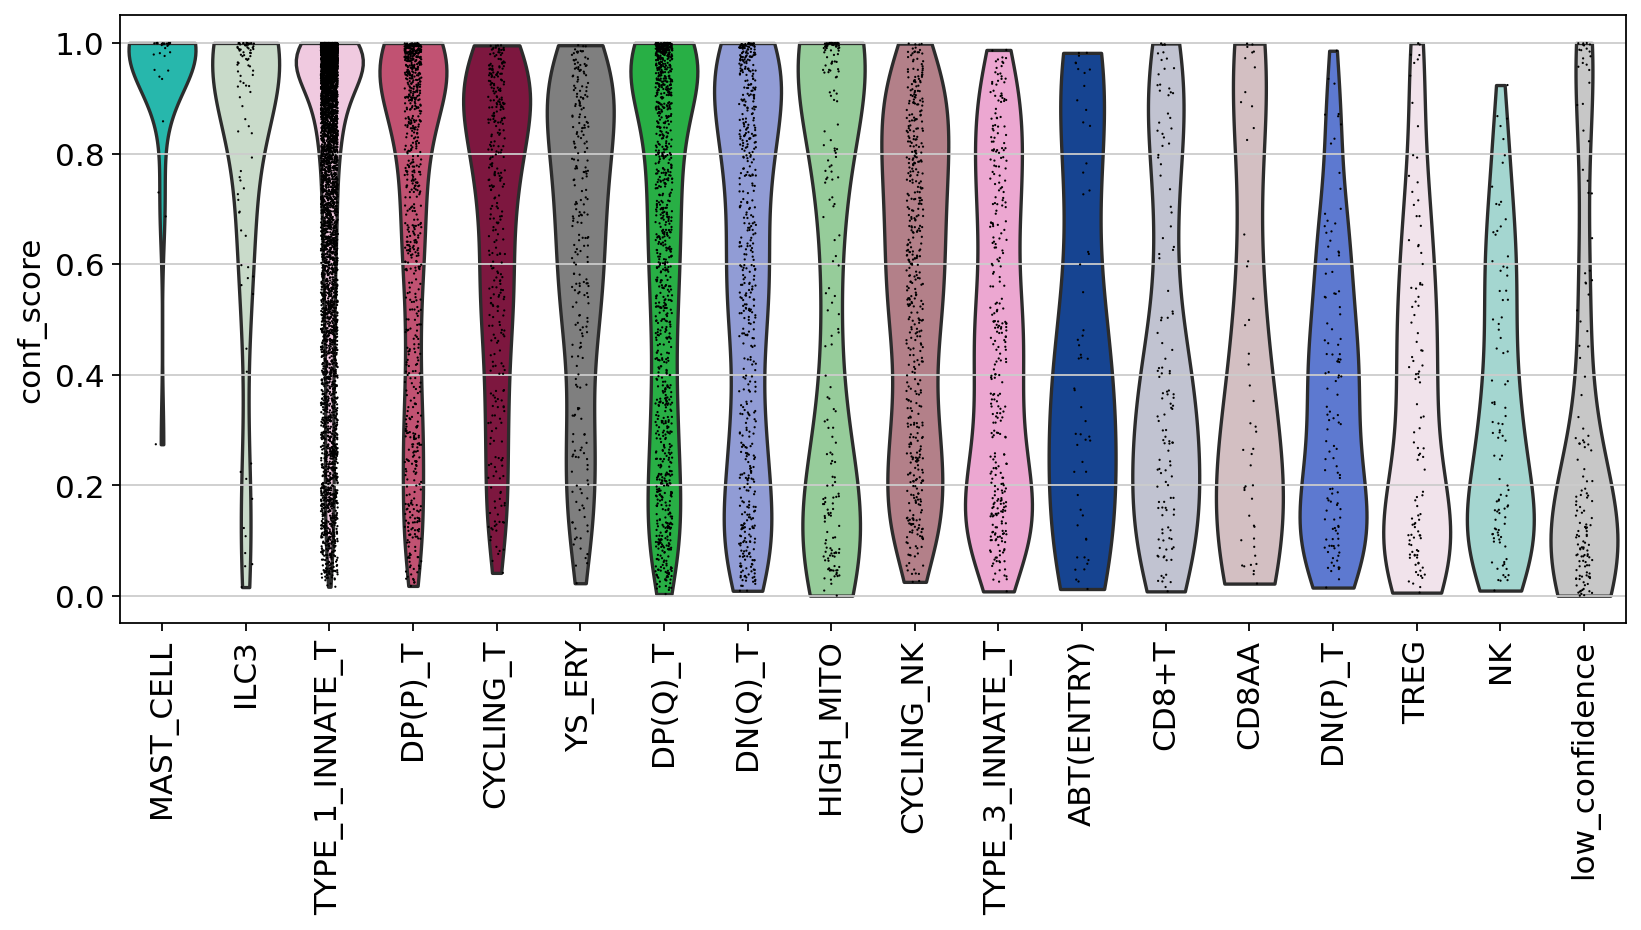

In [74]:
def _plot_sorted_violin(adata, groupby, y_value):
    n_cells_anno = adata.obs[[groupby,y_value]].value_counts(groupby)
    keep_anno = n_cells_anno.index[n_cells_anno > 30]

    mean_sim = adata.obs[[groupby,y_value]].groupby(groupby).mean()
    anno_order = mean_sim.loc[keep_anno].sort_values(y_value, ascending=False).index.tolist()

    adata.var_names_make_unique()
    sc.pl.violin(adata[adata.obs[groupby].isin(keep_anno)], 
                                     y_value, groupby=groupby, rotation=90, 
                                     order=anno_order)

plt.rcParams['figure.figsize'] = [10,5]
_plot_sorted_violin(query_adata, y_value='conf_score', groupby='predicted_labels')

## Compare with existing annotations

<AxesSubplot:xlabel='predicted_labels', ylabel='annotation'>

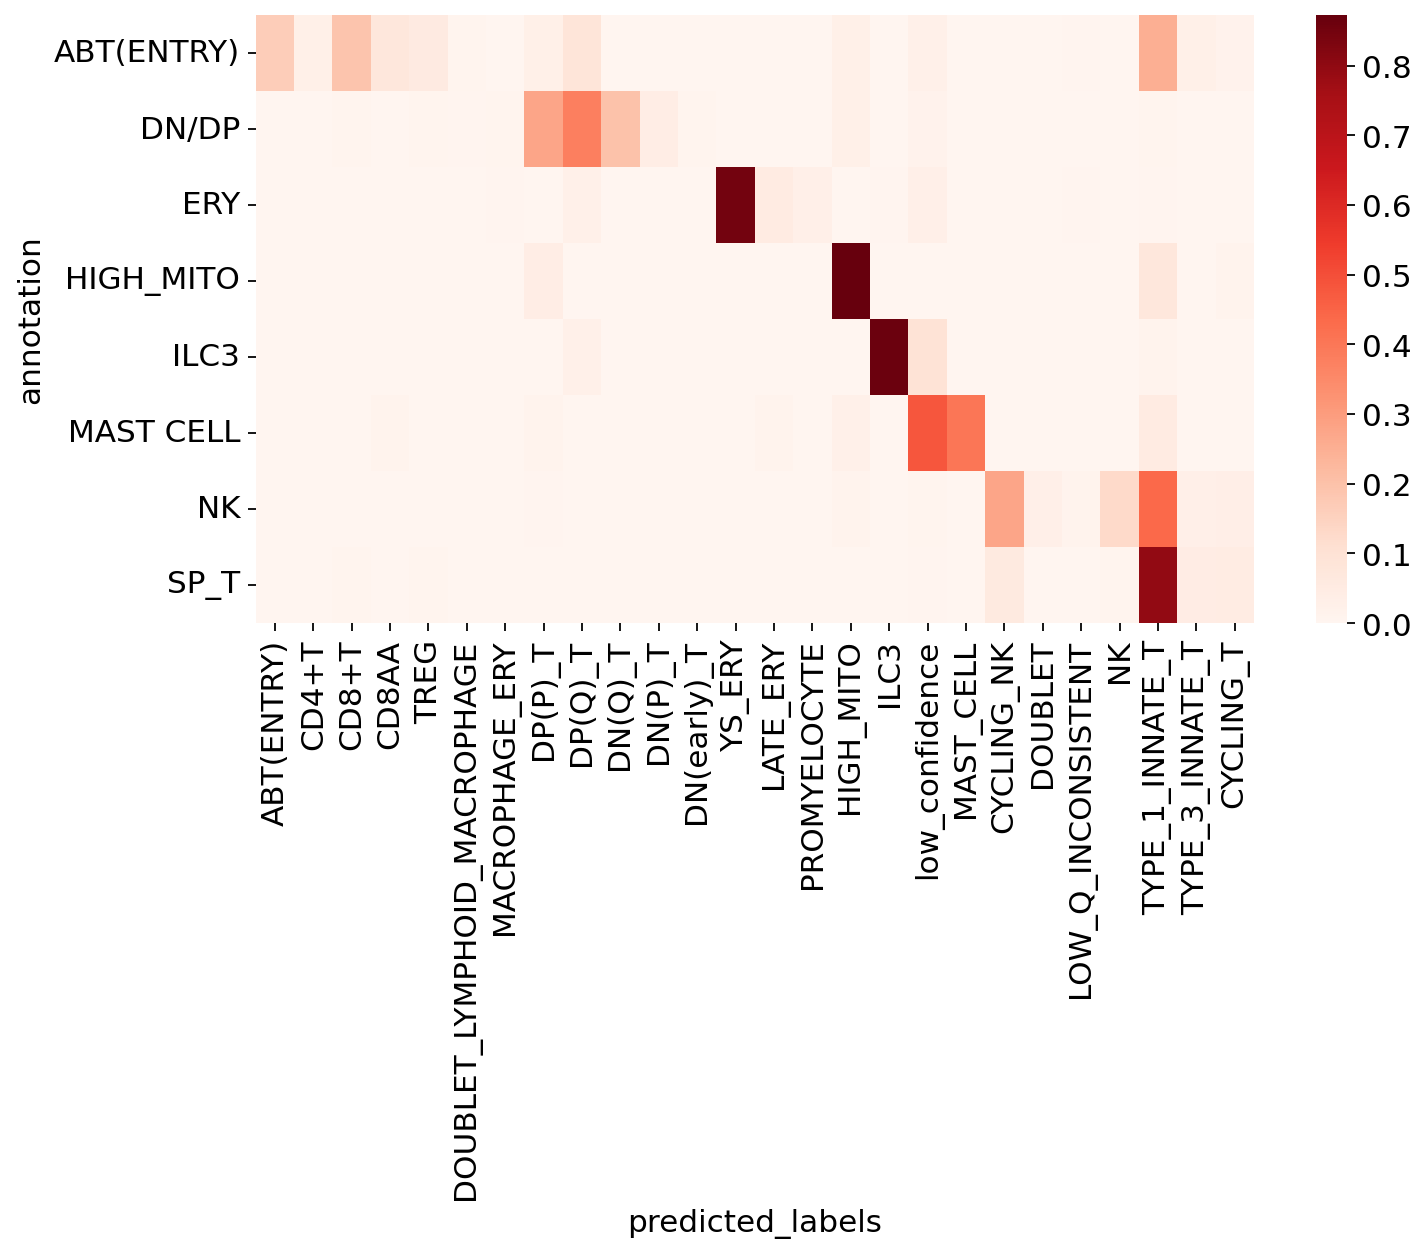

In [110]:
conf_mat = sc.metrics.confusion_matrix('annotation', "predicted_labels",  query_adata.obs, normalize=True)

col_order = conf_mat.idxmax(0).sort_values().index
conf_mat = conf_mat[col_order] ## Sort to have some sort of diagonal
sns.heatmap(conf_mat, xticklabels=True, yticklabels=True, cmap='Reds')

---